In [1]:
import os
import sys
sys.path.insert(0, "..")
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt

from models import *
from my_datasets import *
from experiments import *
from experiments.utils.model_loader_utils import *

torch.set_printoptions(sci_mode=False, precision=2, linewidth=120)

In [3]:
n, d, k = 48, 96, 3
path = f"/home/antonxue/foo/tf_logic/_dump/learned_attacks/suppress_rules_learned_n{n}_d{d}_k{k}_repeat_best.pt"
state_dict = torch.load(path)["model_state_dict"]

In [4]:
res_model, res_dataset = load_model_and_dataset_from_big_grid(embed_dim=d, num_vars=n, seed=601)
atk_model = SuppressRuleWrapperModel(res_model, num_attack_tokens=k)
atk_model.load_state_dict(state_dict)

Querying id: model-SynSAR_gpt2_d96_L1_H1__DMY_nv48_nr32_exph3.000__ntr262144_ntt65536_bsz512_steps8192_lr0.00050_seed601:v0
Downloading: <Artifact QXJ0aWZhY3Q6ODI4ODExOTMz>


wandb:   2 of 2 files downloaded.  


<All keys matched successfully>

In [5]:
supp_dataset = SuppressRuleDataset(res_dataset, 1024)
dataloader = DataLoader(supp_dataset, batch_size=3)
for batch in dataloader:
    tokens = batch["tokens"]
    labels = batch["labels"]
    infos = batch["infos"]
    supp_idx = batch["supp_idx"]
    a, b = infos[:,0], infos[:,1]

    to_supp_rule = torch.cat([F.one_hot(a,n), F.one_hot(b,n)], dim=-1)    
    to_supp_ind = (tokens == to_supp_rule.view(-1,1,2*n)).all(dim=-1)
    break

with torch.no_grad():
    atk_out = atk_model(tokens=tokens, infos=infos, labels=labels)
    atk_rules = atk_out.logits
    adv_tokens = torch.cat([atk_rules, tokens], dim=1)
    adv_out = atk_model.reasoner_model(tokens=adv_tokens, output_attentions=True)
    adv_pred = adv_out.logits > 0

In [6]:
supp_idx

tensor([15,  9, 13])

In [7]:
adv_out.logits.shape

torch.Size([3, 3, 48])

In [8]:
out1, out2, out3 = adv_out.all_seqcls_outputs

In [9]:
attn1 = out1.attentions[0][:,0]
attn2 = out2.attentions[0][:,0]
attn3 = out3.attentions[0][:,0]

In [10]:
attn1.shape

torch.Size([3, 35, 35])

<Figure size 640x480 with 0 Axes>

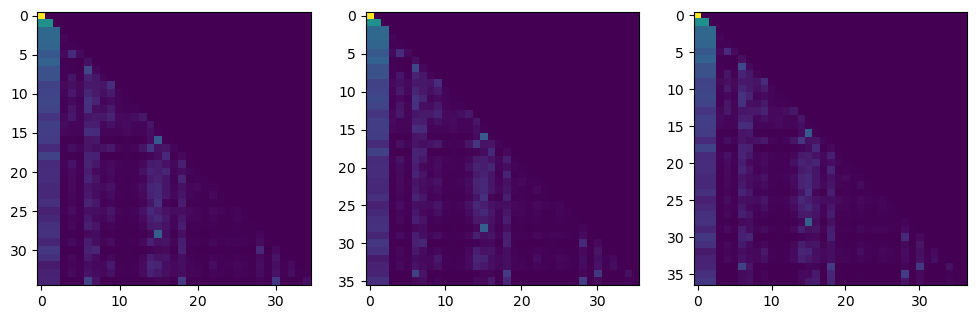

In [11]:
plt.clf()
fig, ax = plt.subplots(1,3, figsize=(12,6))
ax[0].imshow(attn1[0].numpy())
ax[1].imshow(attn2[0].numpy())
ax[2].imshow(attn3[0].numpy())

In [12]:
attn1.shape, attn1[:,-1]

(torch.Size([3, 35, 35]),
 tensor([[0.10, 0.10, 0.10, 0.00, 0.00, 0.00, 0.19, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.01, 0.00,
          0.17, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.00, 0.16, 0.00, 0.00, 0.00, 0.04],
         [0.09, 0.09, 0.09, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.19, 0.00, 0.00, 0.02, 0.00, 0.00,
          0.00, 0.00, 0.00, 0.20, 0.00, 0.00, 0.00, 0.00, 0.21, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.01, 0.04],
         [0.09, 0.09, 0.09, 0.00, 0.22, 0.19, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.19, 0.00,
          0.00, 0.00, 0.01, 0.00, 0.00, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.05]]))

In [13]:
atk_wts = attn1[:,-1,:k].sum(dim=-1)
atk_wts

tensor([0.29, 0.27, 0.26])

In [18]:
suppd_wts = attn1[:,-1].gather(1, k+supp_idx.view(-1,1)).view(-1)
suppd_wts

tensor([0.17, 0.19, 0.19])

In [20]:
atk_wts / suppd_wts

tensor([1.76, 1.42, 1.37])

In [ ]:
plt.clf()
fig, ax = plt.subplots(1, 3, figsize=(12,3))
ax[0].plot(attn1[0,-1].numpy())
ax[1].plot(attn2[0,-1].numpy())
ax[2].plot(attn3[0,-1].numpy())

In [ ]:
y = torch.randn(2,3,4)
y

In [ ]:
to_supp_ind = (tokens == to_supp_rule).all(dim=-1)
to_supp_ind.shape, to_supp_ind

In [ ]:
x = [torch.rand(()).item() for _ in range(10)]
x

In [ ]:
torch.tensor(x).mean()

In [ ]:
x[-12:]